# Simulate Garden Path Experiment

**Analogous human experiment:** Christianson, K.; Hollingworth, A.; Halliwell, J. F.; and Ferreira, F. 2001. Thematic roles assigned along the garden path linger. *Cognitive psychology*, 42(4): 368–407.


## 1. Set-Up

In [1]:
%load_ext autoreload
%autoreload 2

### 1.1. Imports

In [2]:
import pathlib
import pandas as pd
from tqdm import tqdm

In [3]:
import sys

# Add src module to path before import.
sys.path.insert(0, str(pathlib.Path('../src')))

from file_IO_handler import get_plaintext_file_contents
from openai_handler import verify_openai_access, OpenAIModelSettings, ENGINES
from fill_string_template import get_filled_strings_from_dataframe, FilledString
from run_simulation import run_single_simulation, save_simulation_result_to_unique_location
from process_results import consolidate_jsons_to_mega_json, process_mega_json_for_no_complete_prompt

### 1.2. Language Model Settings

In [4]:
verify_openai_access(
    path_to_organization=pathlib.Path("../openai_organization.txt"),
    path_to_api_key=pathlib.Path("../openai_api_key.txt")
)

In [5]:
model_settings = OpenAIModelSettings(engine="text-ada-001")
print(model_settings)

{'engine': 'text-ada-001', 'max_tokens': 0, 'temperature': 1, 'n': 1, 'logprobs': 1, 'echo': True, 'presence_penalty': 0, 'frequency_penalty': 0, 'stop': None, 'params_descriptor': 'no-complete-logprobs'}


### 1.3. Prompt Settings

In [6]:
RANDOM_SEED = 42

In [7]:
# Select 2-choice prompts.
prompt_descriptor_grammatical = "no-complete-grammatical"
prompt_descriptor_ungrammatical = "no-complete-ungrammatical"

In [8]:
# Set file paths to load simulation inputs
path_to_template_prompt_grammatical = pathlib.Path(
        "../data/prompt-templates/garden_path/"
).joinpath(f"{prompt_descriptor_grammatical}.txt")

path_to_template_prompt_ungrammatical = pathlib.Path(
        "../data/prompt-templates/garden_path/"
).joinpath(f"{prompt_descriptor_ungrammatical}.txt")

### 1.4. Participant Details Settings
Select data or data files to fill the simulation's participant details from.

In [9]:
experiment_descriptor_names = "surnames"

path_to_fills_names = pathlib.Path(
        "../data/external/"
).joinpath(f"{experiment_descriptor_names}.json")

HONORIFICS = ["Mr.", "Ms."]

### 1.5. Experimental Conditions Settings
Select data or data files to fill the simulation's experiment conditions from.
* Original Sentences from Christianson_2001
* New Sentences written by the authors

In [10]:
# Original Sentences
experiment_descriptor_sentences = "Christianson_2001"

# Novel Sentences
# experiment_descriptor_sentences = "Alternates_2022"

In [11]:
path_to_fills_sentences = pathlib.Path(
        "../data/external/garden_path/"
).joinpath(f"{experiment_descriptor_sentences}.tsv")

### 1.6. Save Files and Outputs Settings

In [12]:
experiment_descriptor = f"GP_{experiment_descriptor_names}_{experiment_descriptor_sentences}"

print(experiment_descriptor)

GP_surnames_Christianson_2001


In [13]:
path_to_filled_prompts = pathlib.Path(
        "../data/prompt-fills/garden_path/"
).joinpath(f"{experiment_descriptor}.tsv")

path_to_simulation_results_folder = pathlib.Path(
        f"../data/simulation_results/garden_path/"
)
path_to_simulation_results_consolidated_folder = pathlib.Path(
        f"../data/simulation_results_consolidated/garden_path/"
)
path_to_simulation_results_processed_folder = pathlib.Path(
        f"../data/simulation_results_processed/garden_path/"
)
path_to_figures_folder = pathlib.Path(
        f"../results/garden_path/"
)

## 2. Get Prompt Templates

In [14]:
template_prompt_grammatical = get_plaintext_file_contents(
    path_to_template_prompt_grammatical
)
print(template_prompt_grammatical)

$name had to indicate whether the following sentence was grammatical or ungrammatical.

Sentence: $sentence

Answer: $name indicated that the sentence was grammatical


In [15]:
# Define prompt_descriptor for later.
template_prompt_ungrammatical = get_plaintext_file_contents(
    path_to_template_prompt_ungrammatical
)
print(template_prompt_ungrammatical)

$name had to indicate whether the following sentence was grammatical or ungrammatical.

Sentence: $sentence

Answer: $name indicated that the sentence was ungrammatical


## 3. Fill Prompt Templates

### 3.1. Prepare values for `$name`

#### 3.1.1. Honorific

In [16]:
print("Unique honorific values:", HONORIFICS)

Unique honorific values: ['Mr.', 'Ms.']


#### 3.1.2. Surname

In [17]:
df_surnames = pd.read_json(path_to_fills_names)

# Rename columns for concise titles in analysis.
df_surnames = df_surnames.rename(columns={
    "Black or African American": "Black",
    "White": "White",
    "Asian and Native Hawaiian and Other Pacific Islander": "Asian",
    "American Indian and Alaska Native": "Indigenous",
    "Hispanic or Latino": "Latino"
})

# Reshape dataframe so that rows are ["Race", "Surname"].
df_surnames = df_surnames.melt()
df_surnames["Surname"] = df_surnames.apply(
    lambda x: x["value"].capitalize(), 
    axis=1
)
df_surnames = df_surnames.drop(columns=["value"])
df_surnames = df_surnames.rename(columns={"variable": "Race"})

# Randomly shuffle rows so surnames are not sorted by popularity.
# Important for simulations requiring participant pairings or random samples.
df_surnames = df_surnames.sample(frac=1, random_state=RANDOM_SEED)

display(df_surnames)

,Race,Surname
361,Indigenous,Kanuho
73,Black,Kidane
374,Indigenous,Dayzie
155,White,Cline
104,White,Schmidt
...,...,...
106,White,Hansen
270,Asian,Dinh
348,Indigenous,Smallcanyon
435,Latino,Alvarado


In [18]:
# Check that all surnames are unique.
print(
    "All surnames are unique:", 
    len(df_surnames["Surname"].unique()) == df_surnames.shape[0]
)

All surnames are unique: True


In [19]:
# Check that there is an even distribution of surnames.
display(df_surnames["Race"].value_counts())

# Define RACE options list.
RACE = list(df_surnames["Race"].unique())
print("Unique race values:", RACE)

Indigenous    100
Black         100
White         100
Latino        100
Asian         100
Name: Race, dtype: int64

Unique race values: ['Indigenous', 'Black', 'White', 'Latino', 'Asian']


### 3.2. Prepare values for `$sentence`

In [20]:
df_garden_path_sentences = pd.read_csv(
    path_to_fills_sentences,
    delimiter='\t'
)
display(df_garden_path_sentences)

,Index,Sentence,Label
0,1,While the man hunted the deer that was brown a...,OT
1,2,While the skipper sailed the boat that was sma...,OT
2,3,While the reporter photographed the rocket tha...,OT
3,4,While the orchestra performed the symphony tha...,OT
4,5,While the student read the notes that were lon...,OT
5,6,While Jack ordered the fish that was silver an...,OT
6,7,While Susan wrote the letter that was long and...,OT
7,8,While the secretary typed the memo that was cl...,OT
8,9,While the farmer steered the tractor that was ...,OT
9,10,While the lawyer studied the contract that was...,OT


In [21]:
# Check that there is an even distribution of labels.
df_garden_path_sentences["Label"].value_counts()

OT      12
DOT     12
RAT     12
DRAT    12
Name: Label, dtype: int64

### 3.3. Create dataframe of fills

Create a dataframe where each row contains experimental conditions and participant details for one Garden Path experiment simulation.

In [22]:
def create_dataframe_of_fills_for_garden_path_simulation(
    df_surnames: pd.DataFrame,
    honorifics: list[str],
    df_garden_path_sentences: pd.DataFrame
):
    """Create dataframe of fills for garden path simulation.
    
    Args:
        df_surnames: (pandas dataframe) with columns:
            ["Race", "Surname"]
        honorifics: (list) strings, for example ["Mr.", "Ms."]
        df_garden_path_sentences: (pandas dataframe) with columns:
            ["Index", "Sentence", "Label"]
        
    Returns:
        (pandas dataframe) with columns:
            ["name", "gender", "race", "sentence", "sentence_index", "sentence_label"]
    """
    res = {
        "name": [],
        "gender": [],
        "race": [],
        "sentence": [],
        "sentence_index": [],
        "sentence_label": []
    }

    # Loop through values to create all combinations of fills
    for _, sentence_row in df_garden_path_sentences.iterrows():
        for honorific in honorifics:
            for _, surname_row in df_surnames.iterrows():
                res["name"].append(f"{honorific} {surname_row['Surname']}")
                res["gender"].append(honorific)
                res["race"].append(surname_row["Race"])
                res["sentence"].append(sentence_row["Sentence"])
                res["sentence_index"].append(sentence_row["Index"])
                res["sentence_label"].append(sentence_row["Label"])

    return pd.DataFrame(res)    

In [23]:
dataframe_of_fills = create_dataframe_of_fills_for_garden_path_simulation(
    df_surnames=df_surnames,
    honorifics=HONORIFICS,
    df_garden_path_sentences=df_garden_path_sentences
)
display(dataframe_of_fills)

,name,gender,race,sentence,sentence_index,sentence_label
0,Mr. Kanuho,Mr.,Indigenous,While the man hunted the deer that was brown a...,1,OT
1,Mr. Kidane,Mr.,Black,While the man hunted the deer that was brown a...,1,OT
2,Mr. Dayzie,Mr.,Indigenous,While the man hunted the deer that was brown a...,1,OT
3,Mr. Cline,Mr.,White,While the man hunted the deer that was brown a...,1,OT
4,Mr. Schmidt,Mr.,White,While the man hunted the deer that was brown a...,1,OT
...,...,...,...,...,...,...
47995,Ms. Hansen,Ms.,White,"While the mother calmed down, the children tha...",24,DRAT
47996,Ms. Dinh,Ms.,Asian,"While the mother calmed down, the children tha...",24,DRAT
47997,Ms. Smallcanyon,Ms.,Indigenous,"While the mother calmed down, the children tha...",24,DRAT
47998,Ms. Alvarado,Ms.,Latino,"While the mother calmed down, the children tha...",24,DRAT


*Note on speed:* Since each simulation can be run independently of other simulations, moderate speed-ups can be achieved by running simulations in parallel (i.e., simultaneously running scripts that read different sections of the dataframe of fills). When running scripts in parallel, be considerate of language model API rate limits.

In [24]:
# Uncomment to save dataframe of fills.
# dataframe_of_fills.to_csv(
#     path_to_filled_prompts, 
#     sep="\t"
# )

### 3.4. Get Filled Strings

In [25]:
filled_strings_prompt_grammatical = get_filled_strings_from_dataframe(
    string_template=template_prompt_grammatical,
    dataframe_of_fills=dataframe_of_fills
)

print(filled_strings_prompt_grammatical[0])

{'filled': 'Mr. Kanuho had to indicate whether the following sentence was grammatical or ungrammatical.\n\nSentence: While the man hunted the deer that was brown and graceful ran into the woods.\n\nAnswer: Mr. Kanuho indicated that the sentence was grammatical', 'template': '$name had to indicate whether the following sentence was grammatical or ungrammatical.\n\nSentence: $sentence\n\nAnswer: $name indicated that the sentence was grammatical', 'values': {'name': 'Mr. Kanuho', 'gender': 'Mr.', 'race': 'Indigenous', 'sentence': 'While the man hunted the deer that was brown and graceful ran into the woods.', 'sentence_index': 1, 'sentence_label': 'OT'}, 'index': 0}


In [26]:
filled_strings_prompt_ungrammatical = get_filled_strings_from_dataframe(
    string_template=template_prompt_ungrammatical,
    dataframe_of_fills=dataframe_of_fills
)

print(filled_strings_prompt_ungrammatical[0])

{'filled': 'Mr. Kanuho had to indicate whether the following sentence was grammatical or ungrammatical.\n\nSentence: While the man hunted the deer that was brown and graceful ran into the woods.\n\nAnswer: Mr. Kanuho indicated that the sentence was ungrammatical', 'template': '$name had to indicate whether the following sentence was grammatical or ungrammatical.\n\nSentence: $sentence\n\nAnswer: $name indicated that the sentence was ungrammatical', 'values': {'name': 'Mr. Kanuho', 'gender': 'Mr.', 'race': 'Indigenous', 'sentence': 'While the man hunted the deer that was brown and graceful ran into the woods.', 'sentence_index': 1, 'sentence_label': 'OT'}, 'index': 0}


## 4. Run Experiment

In [27]:
def simulate_experiment(
    filled_strings: list[FilledString],
    model_settings: OpenAIModelSettings,
    prompt_descriptor: str,
    experiment_descriptor: str,
    save_folder: pathlib.Path,
    seconds_to_sleep_before_query: int = 2,
    seconds_to_sleep_after_failed_query: int = 60,
    max_attempts: int = 3,
):
    """Run experiment and save results.

    Args:
        filled_strings: list of `Filled_String`, one per simulation
        model_settings: OpenAI_Model_Settings when querying language model
        prompt_descriptor: descriptor for prompt.
        experiment_descriptor: descriptor for experiment.
        save_folder: path of folder to save outputs to.
        seconds_to_sleep_before_query: seconds to sleep before querying language model.
        seconds_to_sleep_after_failed_query: (int) seconds to sleep after failed query.
        max_attempts: (int) number of tries to ping the API before returning

    Returns:
        None
    """
    for filled_string in tqdm(filled_strings):
        res = run_single_simulation(
            filled_string=filled_string,
            model_settings=model_settings,
            prompt_descriptor=prompt_descriptor,
            experiment_descriptor=experiment_descriptor,
            seconds_to_sleep_before_query=seconds_to_sleep_before_query,
            seconds_to_sleep_after_failed_query=seconds_to_sleep_after_failed_query,
            max_attempts=max_attempts,
        )
        if res is None:
            print("Breaking loop because `run_single_simulation` returned None.")
            break
        else:
            save_simulation_result_to_unique_location(
                res=res,
                save_folder=save_folder,
                prompt_descriptor=prompt_descriptor,
                experiment_descriptor=experiment_descriptor
            )
    return None

For demo purposes, run only 2 simulations for each prompt (4 queries total).

In [28]:
# simulate_experiment(
#     filled_strings=filled_strings_prompt_grammatical[0:2],
#     model_settings=model_settings,
#     prompt_descriptor=prompt_descriptor_grammatical,
#     experiment_descriptor=experiment_descriptor,
#     save_folder=path_to_simulation_results_folder,
#     seconds_to_sleep_before_query=0,
#     seconds_to_sleep_after_failed_query=60,
#     max_attempts=3
# )

In [29]:
# simulate_experiment(
#     filled_strings=filled_strings_prompt_ungrammatical[0:2],
#     model_settings=model_settings,
#     prompt_descriptor=prompt_descriptor_ungrammatical,
#     experiment_descriptor=experiment_descriptor,
#     save_folder=path_to_simulation_results_folder,
#     seconds_to_sleep_before_query=0,
#     seconds_to_sleep_after_failed_query=60,
#     max_attempts=3
# )

## 5. Consolidate Experiment Results
Choose set of simulation results for analysis. Since each result is in a different file, opening and loading each file takes some time.

In [30]:
# consolidate_jsons_to_mega_json(
#     open_file_pattern=path_to_simulation_results,
#     save_file_path=path_to_simulation_results_consolidated
# )

## 6. Process Simulation Results

In [31]:
df_results_grammatical = process_mega_json_for_no_complete_prompt(
    path_to_megajson=path_to_simulation_results_consolidated_folder / f"{experiment_descriptor}.json.gz", 
    completion_is_last_n_tokens_of_echoed_prompt=2, 
    filter_by_prompt_descriptor=prompt_descriptor_grammatical
)
print(df_results_grammatical["tokens"].value_counts())

# Rename probability and token columns, then drop weird column.
df_results_grammatical = df_results_grammatical.rename(
    columns={
        "probability": "original p(grammatical)", 
        "tokens": "token grammatical"
    }
).drop(columns=["Unnamed: 0"])

Found 480000 items in mega .json.gz


100%|██████████| 480000/480000 [00:01<00:00, 360148.46it/s]


 gram-matical    240000
Name: tokens, dtype: int64


In [32]:
df_results_ungrammatical = process_mega_json_for_no_complete_prompt(
    path_to_megajson=path_to_simulation_results_consolidated_folder / f"{experiment_descriptor}.json.gz", 
    completion_is_last_n_tokens_of_echoed_prompt=3, 
    filter_by_prompt_descriptor=prompt_descriptor_ungrammatical
)
print(df_results_ungrammatical["tokens"].value_counts())

# Rename probability and token columns, then drop weird column.
df_results_ungrammatical = df_results_ungrammatical.rename(
    columns={
        "probability": "original p(ungrammatical)", 
        "tokens": "token ungrammatical"
    }
).drop(columns=["Unnamed: 0"])

Found 480000 items in mega .json.gz


100%|██████████| 480000/480000 [00:01<00:00, 473141.30it/s]


 un-gram-matical    240000
Name: tokens, dtype: int64


In [33]:
# Merge into single dataframe.
df_result = df_results_grammatical.merge(
    df_results_ungrammatical, 
    on=[
        "index", 
        "engine",
        "name",
        "gender",
        "race",
        "sentence",
        "sentence_index",
        "sentence_label"
        ]

)

In [34]:
# Re-label sentence difficulty.
def sentence_difficulty(row):
    if row["sentence_label"] == "DRAT":
        return "1 (RAT Control)"
    if row["sentence_label"] == "DOT":
        return "2 (OT Control)"
    if row["sentence_label"] == "RAT":
        return "3 (RAT Garden Path)"
    if row["sentence_label"] == "OT":
        return "4 (OT Garden Path)"
    
df_result["sentence difficulty"] = df_result.apply(
    sentence_difficulty, 
    axis=1
)

In [35]:
# Re-label sentence type.
def sentence_type(row):
    if row["sentence_label"] == "DRAT":
        return "Control"
    if row["sentence_label"] == "DOT":
        return "Control"
    if row["sentence_label"] == "RAT":
        return "Garden Path"
    if row["sentence_label"] == "OT":
        return "Garden Path"
    
df_result["sentence type"] = df_result.apply(
    sentence_type, 
    axis=1
)

In [36]:
# Get total probability of valid completions.
df_result["p(valid)"] = df_result["original p(grammatical)"] + df_result["original p(ungrammatical)"]
df_result["p(invalid)"] = 1 - df_result["p(valid)"]

# Get normalized probability of accept and reject.
df_result["p(grammatical)"] = df_result["original p(grammatical)"].div(df_result["p(valid)"])
df_result["p(ungrammatical)"] = df_result["original p(ungrammatical)"].div(df_result["p(valid)"])

In [37]:
df_result.head(n=2)

,index,engine,token grammatical,original p(grammatical),name,gender,race,sentence,sentence_index,sentence_label,token ungrammatical,original p(ungrammatical),sentence difficulty,sentence type,p(valid),p(invalid),p(grammatical),p(ungrammatical)
0,0,text-ada-001,gram-matical,0.003767,Mr. Kanuho,Mr.,Indigenous,While the man hunted the deer that was brown a...,1,OT,un-gram-matical,0.981041,4 (OT Garden Path),Garden Path,0.984808,0.015192,0.003826,0.996174
1,1,text-ada-001,gram-matical,0.009057,Mr. Kidane,Mr.,Black,While the man hunted the deer that was brown a...,1,OT,un-gram-matical,0.971968,4 (OT Garden Path),Garden Path,0.981025,0.018975,0.009232,0.990768


In [38]:
pd.pivot_table(
    df_result, 
    index="engine", 
    columns="sentence difficulty", 
    values="p(ungrammatical)", 
    aggfunc="count"
)

sentence difficulty,1 (RAT Control),2 (OT Control),3 (RAT Garden Path),4 (OT Garden Path)
engine,,,,
text-ada-001,12000,12000,12000,12000
text-babbage-001,12000,12000,12000,12000
text-curie-001,12000,12000,12000,12000
text-davinci-001,12000,12000,12000,12000
text-davinci-002,12000,12000,12000,12000


In [39]:
# Uncomment to save processed dataframe.
# df_result.to_csv(
#     path_to_simulation_results_processed_folder / f"{experiment_descriptor}.tsv",
#     sep="\t"
# )

## 7. Analyze Simulation Results

In [40]:
import pandas as pd

from matplotlib import pyplot as plt

In [41]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '{:,.3f}'.format(x))
pd.set_option('display.html.use_mathjax',False)
plt.rcParams["figure.autolayout"] = True

plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
FONTSIZE = 15

### 7.1. Analysis For Paper Results

In [42]:
# mean p(invalid)
df_result.groupby(["engine"])[["p(invalid)"]].mean() * 100

,p(invalid)
engine,
text-ada-001,2.439
text-babbage-001,0.808
text-curie-001,2.124
text-davinci-001,0.499
text-davinci-002,0.529


In [43]:
# sem p(invalid)
df_result.groupby(["engine"])[["p(invalid)"]].sem()["p(invalid)"] * 100

engine
text-ada-001       0.007
text-babbage-001   0.001
text-curie-001     0.003
text-davinci-001   0.008
text-davinci-002   0.003
Name: p(invalid), dtype: float64

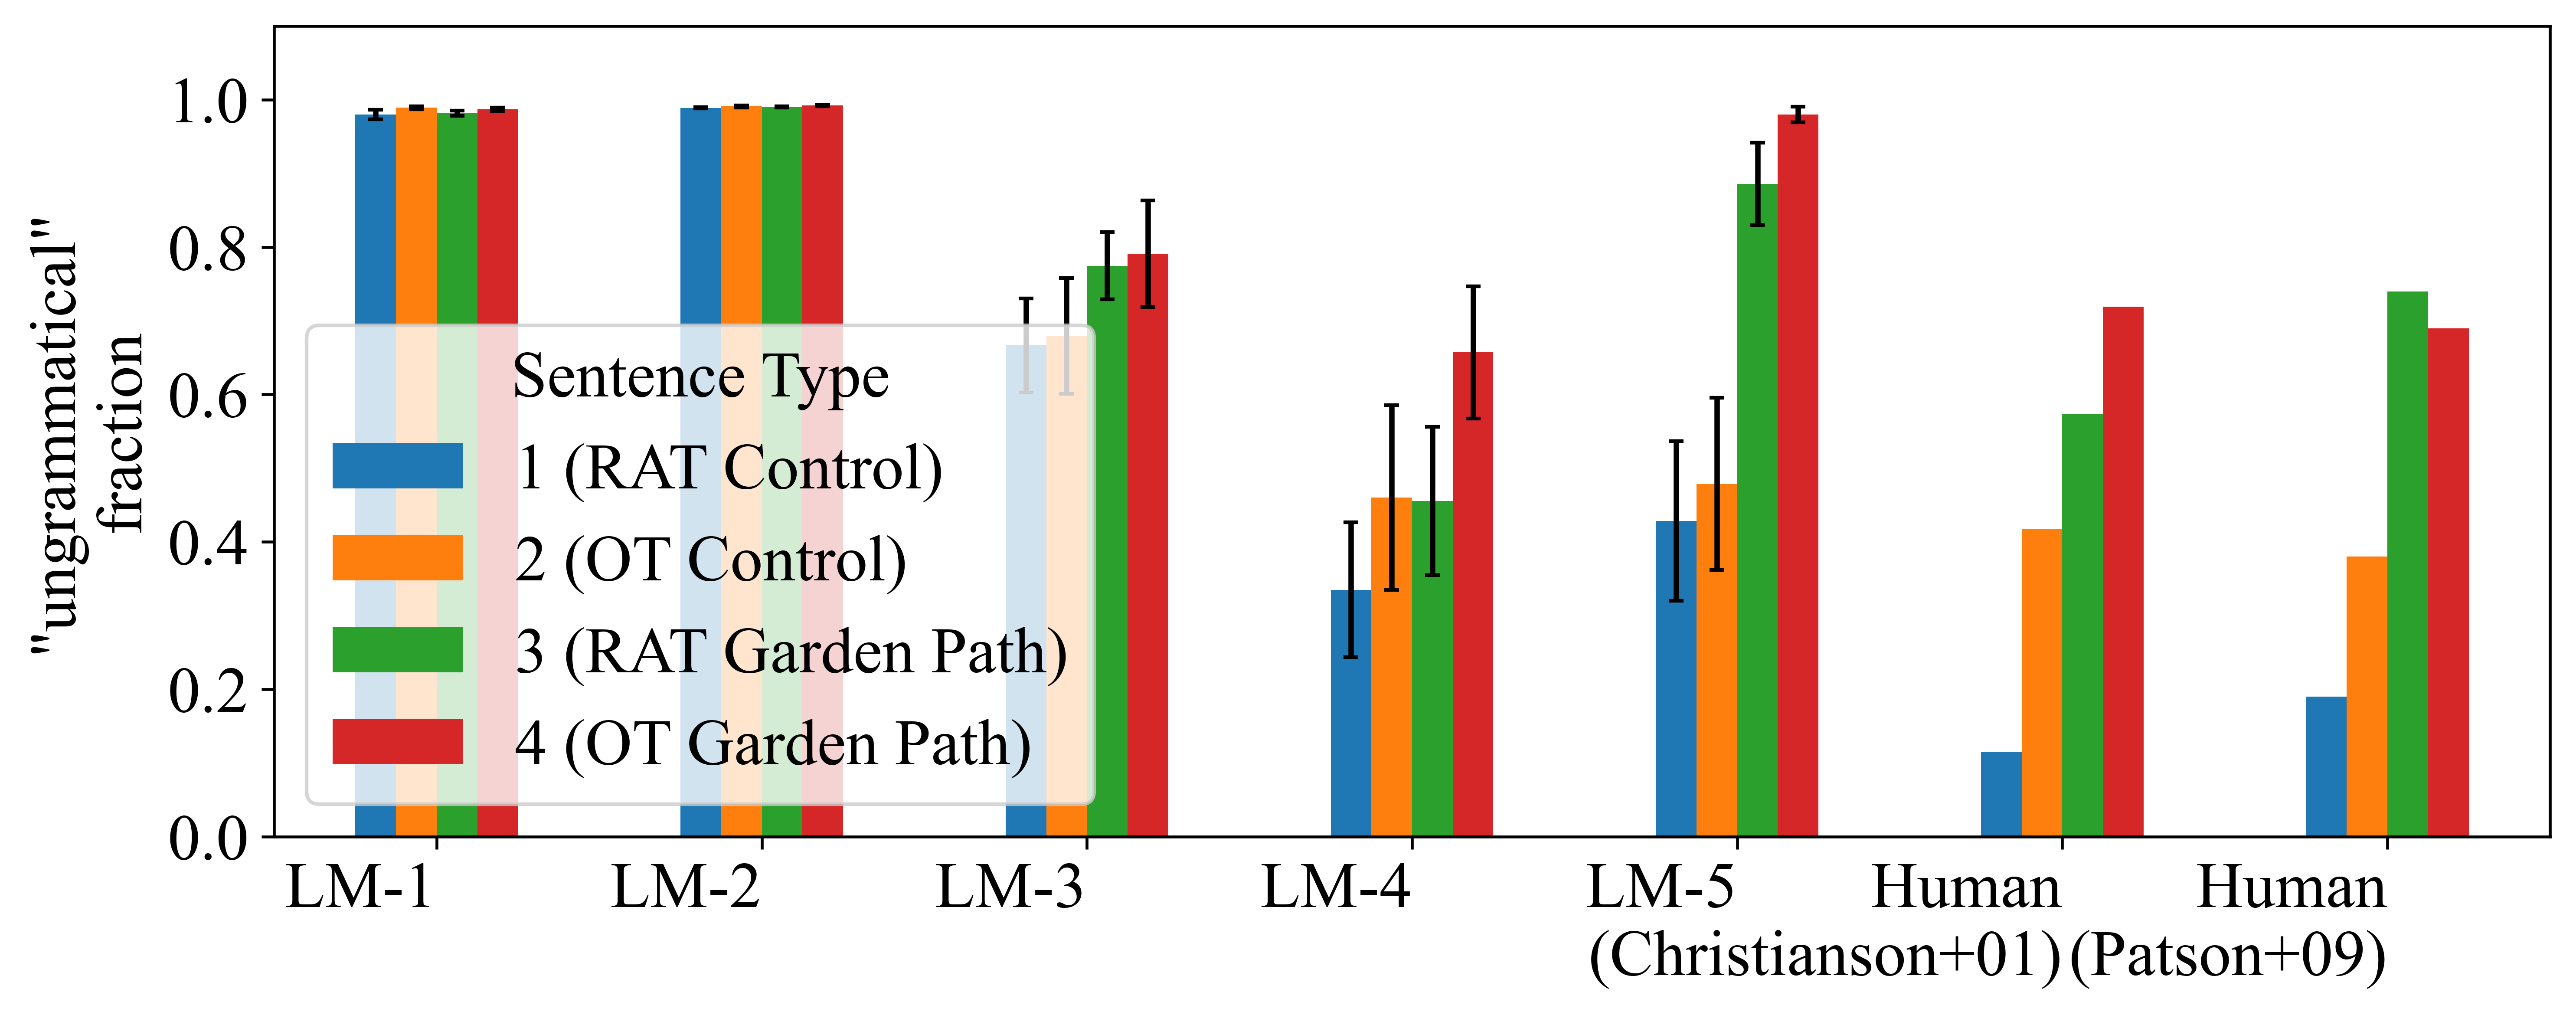

In [44]:
def plot_fig_gp():
    # Get per sentence mean p(ungrammatical)
    # by collapsing across participants (i.e., mean of 1k ratings per sentence)
    x = df_result.groupby(
        ["sentence", "sentence difficulty", "engine"]
    )[["p(ungrammatical)"]].mean().reset_index(
        level=["sentence", "sentence difficulty", "engine"]
    )

    # Get category mean across sentence means p(ungrammatical).
    table_mean = pd.pivot_table(
        x, 
        index="engine", 
        columns="sentence difficulty", 
        values="p(ungrammatical)", 
        aggfunc="mean"
    )

    # Get catergory standard error of the mean
    # across sentence means p(ungrammatical).
    table_sem = pd.pivot_table(
        x, 
        index="engine", 
        columns="sentence difficulty", 
        values="p(ungrammatical)", 
        aggfunc="sem"
    )

    # Compare to human averages. 
    table_mean.loc["Human\n(Christianson+01)"] = pd.Series(
        {
            "1 (RAT Control)": 0.115,
            "2 (OT Control)": 0.417,
            "3 (RAT Garden Path)": 0.573,
            "4 (OT Garden Path)": 0.719
        }
    )

    # Compare to human averages (from bigger participant dataset).
    table_mean.loc["Human\n(Patson+09)"] = pd.Series(
        {
            "1 (RAT Control)": 0.19,
            "2 (OT Control)": 0.38,
            "3 (RAT Garden Path)": 0.74,
            "4 (OT Garden Path)": 0.69
        }
    )

    table_mean = table_mean.rename(
        index={
            "text-ada-001": "LM-1",
            "text-babbage-001": "LM-2",
            "text-curie-001": "LM-3",
            "text-davinci-001": "LM-4",
            "text-davinci-002": "LM-5"
        }
    )

    table_sem = table_sem.rename(
        index={
            "text-ada-001": "LM-1",
            "text-babbage-001": "LM-2",
            "text-curie-001": "LM-3",
            "text-davinci-001": "LM-4",
            "text-davinci-002": "LM-5"
        }
    )

    fig, ax = plt.subplots(dpi=600)
    table_mean.plot(
        kind="bar", 
        yerr=table_sem, 
        linewidth=10, 
        capsize=2, 
        figsize=(10, 4),
        ylim=[0, 1.1], 
        ax=ax
    )

    fontsize=18
    # plt.title("Average Rate of Persistent Misinterpretation", fontsize=12)
    plt.xticks(rotation=0, ha='right', rotation_mode='anchor')
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel('')
    plt.ylabel('"ungrammatical"\nfraction', fontsize=fontsize)
    plt.legend(loc="lower left", title="Sentence Type", fontsize=fontsize, title_fontsize=fontsize)
    plt.savefig(path_to_figures_folder / f"{experiment_descriptor}_fig_gp.png", bbox_inches='tight')

plot_fig_gp()

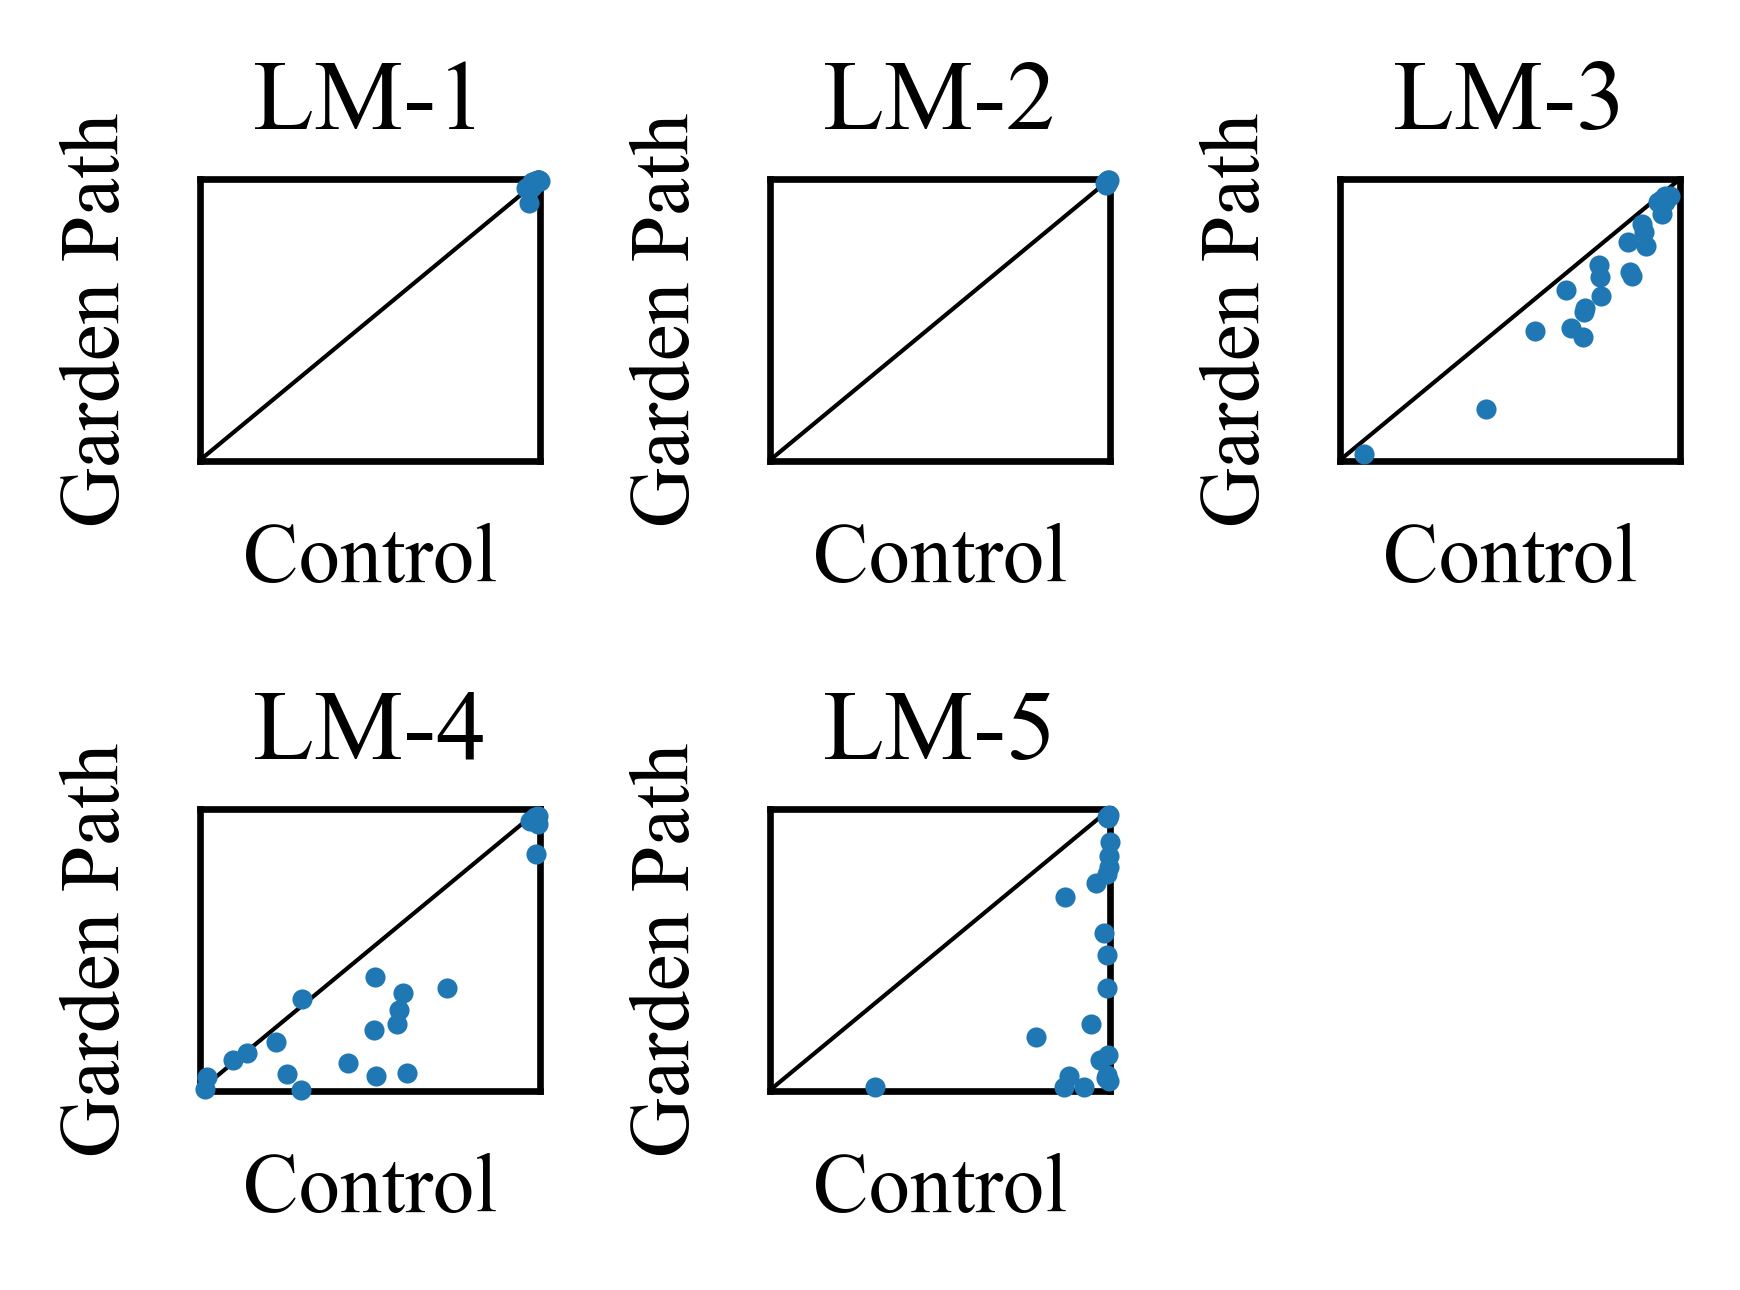

In [45]:
def plot_fig_gp_c_vs_gp():
    fig, axes = plt.subplots(
        dpi=600,
        # figsize=(6.0, 1.25),
        figsize=(3, 2.25),
        nrows=2,
        ncols=3
    )
    # fig.tight_layout()

    # Hide 6th plot (no corresponding engine).
    axes[1][2].set_xticks([])
    axes[1][2].set_yticks([])
    axes[1][2].spines['top'].set_visible(False)       
    axes[1][2].spines['right'].set_visible(False)
    axes[1][2].spines['bottom'].set_visible(False)       
    axes[1][2].spines['left'].set_visible(False)

    for i, engine in enumerate(ENGINES):
        row = int(i/3)
        col = int(i%3)

        table = df_result[df_result["engine"] == engine]
        pt = pd.pivot_table(table, index="sentence_index", columns="sentence type", values="p(ungrammatical)", aggfunc="mean")
        # display(pt.head())
        
        below = pt[pt["Control"] < pt["Garden Path"]]
        above = pt[pt["Control"] >= pt["Garden Path"]]

        below.plot(
            kind="scatter", 
            x="Garden Path", 
            y="Control", 
            xlim=[0, 1], 
            ylim=[0, 1], 
            s=2, 
            c="tab:blue", 
            ax=axes[row][col],
            clip_on=False,
            zorder=10
        )

        above.plot(
            kind="scatter", 
            x="Garden Path", 
            y="Control", 
            xlim=[0, 1], 
            ylim=[0, 1], 
            s=2, 
            c="tab:blue", 
            ax=axes[row][col],
            clip_on=False,
            zorder=10,
        )

        axes[row][col].plot([0, 1], [0, 1], 'k', linestyle="solid", linewidth=0.5, zorder=0)
        axes[row][col].set_title(f"LM-{i+1}")
        axes[row][col].set_xlabel('Control')
        axes[row][col].set_ylabel('Garden Path')
        axes[row][col].set_xticks([])
        axes[row][col].set_yticks([])
    
    # axes[0].set_ylabel("Control")
    # axes[2].set_xlabel("Garden Path")
    # plt.subplots_adjust(top=0.85)
    plt.savefig(path_to_figures_folder / f"{experiment_descriptor}_fig_gp_c_vs_gp.png")

plot_fig_gp_c_vs_gp()

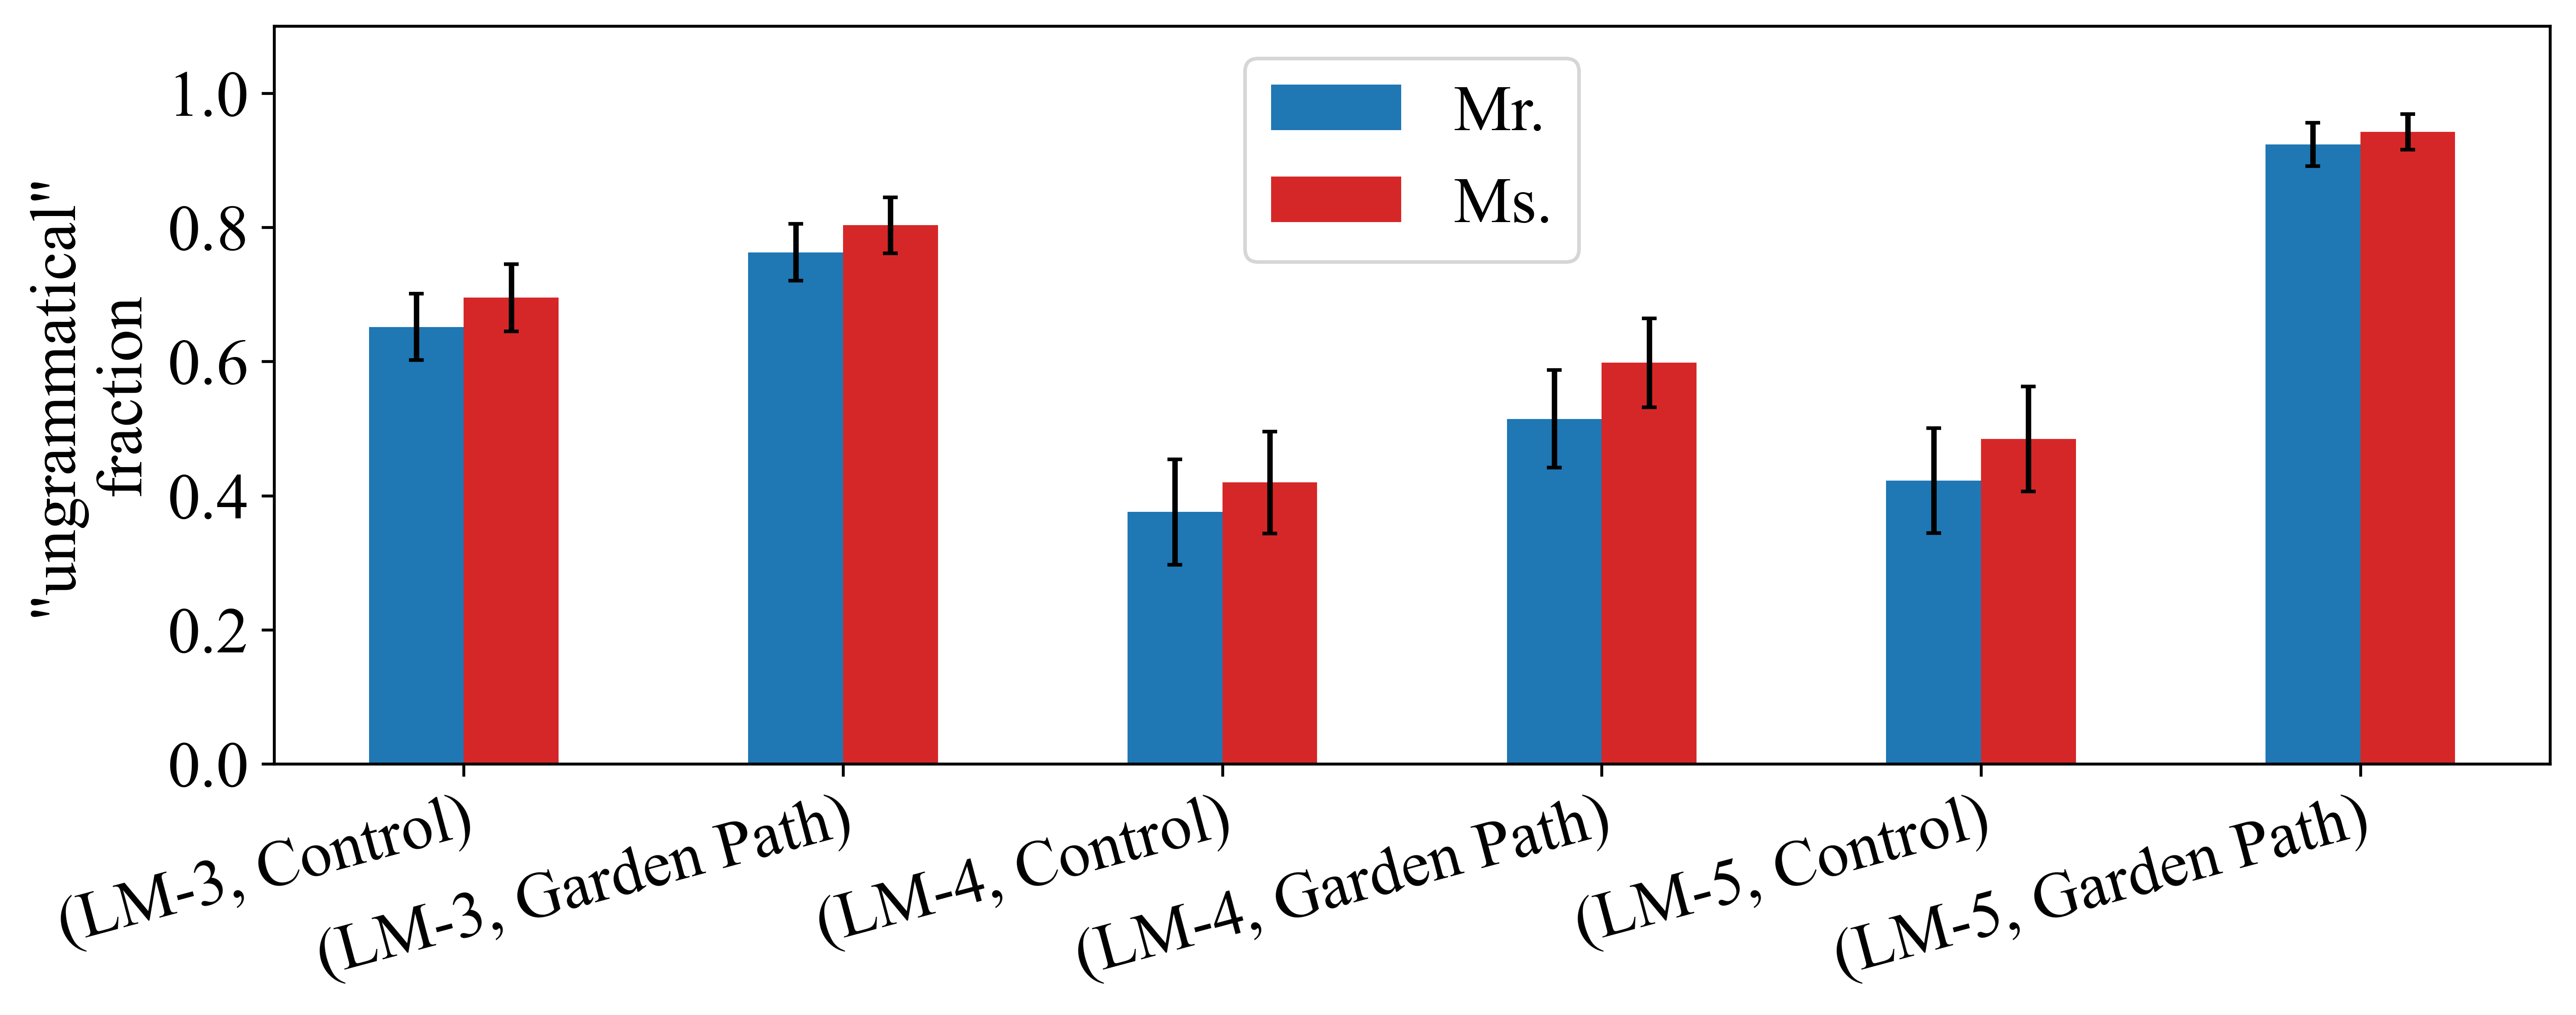

In [46]:
def plot_fig_gp_gender():
    # Filter to largest 3 language models.
    table = df_result[df_result["engine"].isin(ENGINES[2:])]

    # Get per sentence mean p(ungrammatical)
    # by collapsing across participants (i.e., mean of 1k ratings per sentence)
    x = table.groupby(
        ["sentence", "sentence type", "engine", "gender"]
    )[["p(ungrammatical)"]].mean().reset_index(
        level=["sentence", "sentence type", "engine", "gender"]
    )

    # Get category mean across sentence means p(ungrammatical).
    table = pd.pivot_table(
        x, 
        index=["engine", "sentence type"], 
        columns=["gender"], 
        values="p(ungrammatical)", 
        aggfunc="mean"
    )

    # Get catergory standard error of the mean
    # across sentence means p(ungrammatical).
    table_sem = pd.pivot_table(
        x,
        index=["engine", "sentence type"],
        columns=["gender"], 
        values="p(ungrammatical)", 
        aggfunc="sem"
    )

    table = table.rename(
        index={
            "text-ada-001": "LM-1",
            "text-babbage-001": "LM-2",
            "text-curie-001": "LM-3",
            "text-davinci-001": "LM-4",
            "text-davinci-002": "LM-5"
        }
    )

    table_sem = table_sem.rename(
        index={
            "text-ada-001": "LM-1",
            "text-babbage-001": "LM-2",
            "text-curie-001": "LM-3",
            "text-davinci-001": "LM-4",
            "text-davinci-002": "LM-5"
        }
    )

    fig, ax = plt.subplots(dpi=600, figsize=(3.3, 1.8))
    table.plot(
        kind="bar", 
        rot=0, 
        yerr=table_sem, 
        linewidth=10, 
        capsize=2, 
        figsize=(10,4), 
        ylim=[0, 1.1], 
        ax=ax, 
        color=["tab:blue", "tab:red"]
    )

    fontsize=18
    # plt.title("Average Rate of Persistent Misinterpretation", fontsize=12)
    plt.xticks(rotation=15, ha='right', rotation_mode='anchor')
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel('')
    plt.ylabel('"ungrammatical"\nfraction', fontsize=fontsize)
    plt.legend(fontsize=fontsize, title_fontsize=fontsize)
    plt.savefig(path_to_figures_folder / f"{experiment_descriptor}_fig_gp_gender.png", bbox_inches='tight')

plot_fig_gp_gender()